In [32]:
import pandas as pd
import numpy as np
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
pd.options.mode.chained_assignment = None  # Disable the warning
from sklearn import linear_model

In [3]:
def format_float(x):
    return f'{x:.10f}'

## setup

In [26]:
path = "../../Data/regression/"
models = ["bprmf", "bprmf_V", "bprmf_F", "bprmf_neural"]
results = pd.DataFrame(columns=["model", "avg_rmse", "rmse_runs"])

## EBM without confounder

In [ ]:
ebm = ExplainableBoostingRegressor(feature_types=["nominal", "continuous", "continuous", "continuous", "continuous"],
                                   learning_rate=0.01, 
                                   max_bins= 512, 
                                   min_samples_leaf= 3
                                   )

data = pd.read_csv(path + "bprmf_regression_data.csv")

rmse_runs = []
for i in range(0,5):
    print("run:", i)
    # split data into train and test while keeping the ratio of labels
    train = data.groupby('label').apply(lambda x: x.sample(frac=0.8, random_state=i)).reset_index(level=0, drop=True)
    train = train.sample(frac=1)
    test = data.drop(train.index).sample(frac=1)
    
    # log transformation
    train[["status_count", "followers_count", "friend_count"]] = train[
            ["status_count", "followers_count", "friend_count"]].applymap(lambda x: x + 1)
    train[["status_count", "followers_count", "friend_count"]] = train[
            ["status_count", "followers_count", "friend_count"]].apply(np.log)
    test[["status_count", "followers_count", "friend_count"]] = test[
            ["status_count", "followers_count", "friend_count"]].applymap(lambda x: x + 1)
    test[["status_count", "followers_count", "friend_count"]] = test[
            ["status_count", "followers_count", "friend_count"]].apply(np.log)
    
    # split into features and target
    X_train = train[["verified", "register_time", "status_count", "followers_count", "friend_count"]]
    X_test = test[["verified", "register_time", "status_count", "followers_count", "friend_count"]]
    Y_train = train["label"]
    Y_test = test["label"]
    
    # Train the model
    ebm.fit(X_train, Y_train)
    # Make predictions on the test set
    y_pred = ebm.predict(X_test)
    print("Mean prediction:", y_pred.mean())
    print("Mean label:", Y_test.mean())
    # Calculate and print the Root Mean Squared Error (RMSE)
    rmse_runs.append(mean_squared_error(Y_test, y_pred, squared=False))


temp = pd.DataFrame([{"model": "Base", "avg_rmse": np.mean(rmse_runs), "rmse_runs": rmse_runs}])
results = pd.concat([results, temp], ignore_index=True)

## EBM with confounder

In [ ]:
f_types = ["nominal"]
f_types.extend(["continuous"] * 68)
ebm = ExplainableBoostingRegressor(feature_types=f_types, 
                                   learning_rate=0.01, 
                                   max_bins= 512, 
                                   min_samples_leaf= 3
                                   )

global_bprmf_V = [] # save global explanation for bprmf_V to understand causal effects of user attributes
results = results.head(1)
for m in models:
    print("model:", m)
    data = pd.read_csv(path + m + "_regression_data.csv")


    rmse_runs = []
    for i in range(0,5):
        print("run:", i)
        # split data into train and test while keeping the ratio of labels
        train = data.groupby('label').apply(lambda x: x.sample(frac=0.8, random_state=i)).reset_index(level=0, drop=True)
        train = train.sample(frac=1, random_state=i)
        test = data.drop(train.index).sample(frac=1)
        
        # log transformation
        train[["status_count", "followers_count", "friend_count"]] = train[
                ["status_count", "followers_count", "friend_count"]].applymap(lambda x: x + 1)
        train[["status_count", "followers_count", "friend_count"]] = train[
                ["status_count", "followers_count", "friend_count"]].apply(np.log)
        test[["status_count", "followers_count", "friend_count"]] = test[
                ["status_count", "followers_count", "friend_count"]].applymap(lambda x: x + 1)
        test[["status_count", "followers_count", "friend_count"]] = test[
                ["status_count", "followers_count", "friend_count"]].apply(np.log)
        
        # split into features and target
        Y_train = train["label"]
        Y_test = test["label"]
        X_train = train.drop(["label", "user_id"], axis=1)
        X_test = test.drop(["label", "user_id"], axis=1)
        
        # Train the model
        ebm.fit(X_train, Y_train)
        
        # Make predictions on the test set
        y_pred = ebm.predict(X_test)
        print("Mean prediction:", y_pred.mean())
        
        # Calculate and print the Root Mean Squared Error (RMSE)
        rmse_runs.append(mean_squared_error(Y_test, y_pred, squared=False))
        
        if m == "bprmf_V":
            ebm_global = ebm.explain_global()
            global_bprmf_V.append(ebm_global)
            # show example of global explanation
            if i == 0:
                show(ebm.explain_global())
    
    temp = pd.DataFrame([{"model": m+"_log", "avg_rmse": np.mean(rmse_runs), "rmse_runs": rmse_runs}])
    results = pd.concat([results, temp], ignore_index=True)
    print("finished model:", m)

In [ ]:
results.to_csv("../results/causality/ebm_results_5runs.csv", index=False, float_format=format_float)
results

## ttest

In [20]:
# ttest ablation study
import ast
results = pd.read_csv("../results/causality/ebm_results_5runs.csv")
# literal eval of mse_runs column
base_results = ast.literal_eval(results.iloc[0]["mse_runs"])
bprmf_results = ast.literal_eval(results.iloc[1]["mse_runs"])
ttest = stats.ttest_ind(base_results, bprmf_results, equal_var=False)
print(ttest)

Ttest_indResult(statistic=0.8951741762469368, pvalue=0.3969501867531201)


### feature importance

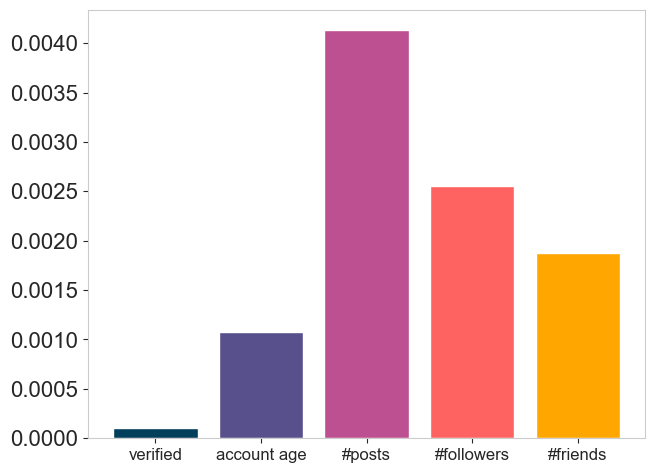

In [16]:
feature_importance = ebm_global.data()
feature_names = ["verified", "account age", "#posts", "#followers", "#friends"]
X_axis = np.arange(len(feature_names))

ax = plt.subplot(111)
plt.bar(X_axis, feature_importance["scores"][:5], label=feature_names, color=['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'])
plt.tight_layout()
plt.xticks(X_axis, feature_names, fontsize=12)
plt.yticks(fontsize=16)
plt.grid(False)
plt.gca().tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

### Plot causal effects

In [ ]:
def get_ebm_data(ebm_global, f):
    idx = ebm_global.selector.index[ebm_global.selector['Name'] == f][0]
    data_dict = ebm_global.data(idx)
    x_vals = data_dict["names"].copy()
    y_vals = data_dict["scores"].copy()
    upper_bounds = data_dict["upper_bounds"].copy()
    lower_bounds = data_dict["lower_bounds"].copy()
    
    # Rearrangements
    y_vals = np.r_[y_vals, y_vals[np.newaxis, -1]]
    upper_bounds = np.r_[upper_bounds, upper_bounds[np.newaxis, -1]]
    lower_bounds = np.r_[lower_bounds, lower_bounds[np.newaxis, -1]]
    x_vals = np.array(x_vals)
    
    return x_vals, y_vals, upper_bounds, lower_bounds, idx

def plot(x, y, f, idx):
    # Create plot
    plt.plot(x, y)
    plt.xlabel(f)
    plt.ylabel(f'$k_{idx+1}$({f})')
    plt.show()

In [ ]:
# causal effect of categorical feature "verified"
x_vals, y_vals, upper_bounds, lower_bounds, idx = get_ebm_data(ebm_global, "verified")   
y_vals = np.r_[y_vals[:-1]]
upper_bounds = np.r_[upper_bounds[:-1]]
lower_bounds = np.r_[lower_bounds[:-1]]
conf = [lower_bounds, upper_bounds]
print(x_vals, y_vals, conf)

In [ ]:
# plot causal effects for every numerical feature
for f in X_train.columns[1:]:
    print(f)
    feature_names = ["verfied", "account age", "#posts", "#followers", "#friends"]
    x_vals, y_vals, upper_bounds, lower_bounds, idx = get_ebm_data(ebm_global, f)        
    
    # Create plot
    # plot(x, y_vals, f, idx)
    plt.plot(x_vals, np.zeros(len(x_vals)), color='lightgrey')
    plt.plot(x_vals, y_vals)
    plt.plot(x_vals, upper_bounds, linestyle='dashed', color='orange')
    plt.plot(x_vals, lower_bounds, linestyle='dashed', color='orange')
    
    plt.xlabel(feature_names[idx], fontsize=14)
    plt.ylabel("Score", fontsize=14)
    plt.xlim([x_vals.min(), x_vals.max()])
    plt.grid(False)
    plt.gca().tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelsize=14)
    plt.show()